# ADA / Applied Data Analysis
<h2 style="color:#a8a8a8">Homework 5 - Taming text<br>
Aimée Montero, Alfonso Peterssen, Cyriaque Brousse</h2>

## Background
In this homework you will explore a relatively large corpus of emails released in public during the
[Hillary Clinton email controversy](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy).
You can find the corpus in the `hillary-clinton-emails` directory of this repository, while more detailed information 
about the [schema is available here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Assignment
1. Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.<br><br>

2. Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?<br><br>

3. Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.<br><br>

4. *BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

## Part 1 - Word clouds

Let's first import the required libraries for the homework:

In [1]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's take a look at our data:

In [2]:
data = pd.read_csv("./hillary-clinton-emails/Emails.csv")
data.head(5)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


We want to keep only the fields that contain text data. That is, `ExtractedSubject` and `ExtractedBodyText`.<br>
We drop the `NA` values, since they contain no text.

In [3]:
raw_mails = ' '.join(list(data.ExtractedSubject.dropna())
                   + list(data.ExtractedBodyText.dropna()))
raw_mails[:130]

'FW: Wow Re: Chris Stevens FVV: Cairo Condemnation - Final Meet The Right Wing Extremist Behind Anti-Muslim Film That Sparked Deadl'

### First wordcloud attempt

We display a first wordcloud without doing any preprocessing step:

In [6]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(raw_mails)

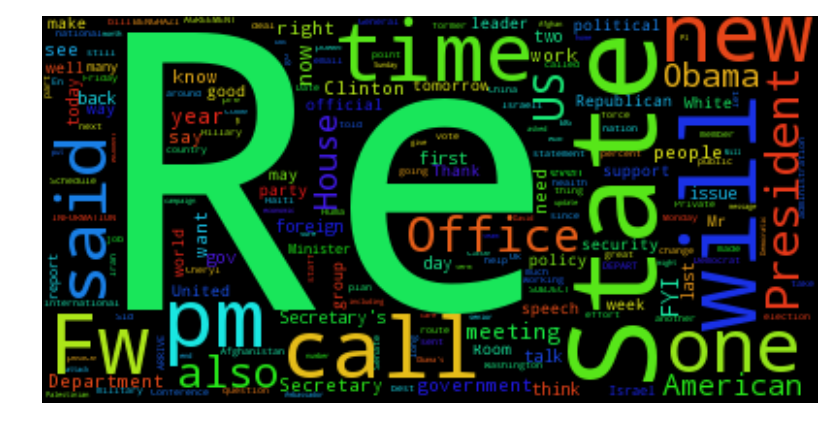

In [7]:
plt.subplots(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

A first problem is that the cloud contains many parasite tokens that are not words that bring much information to us: for instance, "Fw", "Re", "pm", "am", etc.<br>
We also notice that there are also actual words like "new", "call", "one", that don't bring any information either. These so-called **stopwords** need to be removed.

### Tokenization

For now, `raw_mails` is just a long string where every email and its subject is concatenated:

In [8]:
print(type(raw_mails), len(raw_mails))

<class 'str'> 3778333


What we want is to tokenize this string into separate words. This is done with a **tokenizer**:

In [9]:
from nltk import word_tokenize

In [10]:
tokens = word_tokenize(raw_mails)
tokens[:10]

['FW', ':', 'Wow', 'Re', ':', 'Chris', 'Stevens', 'FVV', ':', 'Cairo']

### Lowerization

We want to transform all the tokens to lowercase, with the notable exception of `US` (the country) that risks being matched to `us` (the pronoun).

In [11]:
lowercase_tokens = [w.lower() for w in tokens if w not in ['US', 'U.S.']]

### Punctuation and stopwords

To remove the stopwords, we use a **stopword dictionary** provided by the NLTK API.<br>
Additionally, we remove the punctuation marks.

In [21]:
from string import punctuation
from nltk.corpus import stopwords
import nltk

In [22]:
custom_sw = ['pm', 'am', 're', 'fw', 'fvv', '…', 'n\'t']
stop = stopwords.words('english') + list(punctuation) + custom_sw

In [23]:
filtered_tokens = list(filter(lambda w: w not in stop, lowercase_tokens))
filtered_tokens[:10]

['wow',
 'chris',
 'stevens',
 'cairo',
 'condemnation',
 'final',
 'meet',
 'right',
 'wing',
 'extremist']

### Stemming

We are now trying to map each token to its stem. For example:
- `reading => read`
- `reader => read`
- `read => read`

In [25]:
stemmer = nltk.PorterStemmer()
stems = [stemmer.stem(token) for token in filtered_tokens]

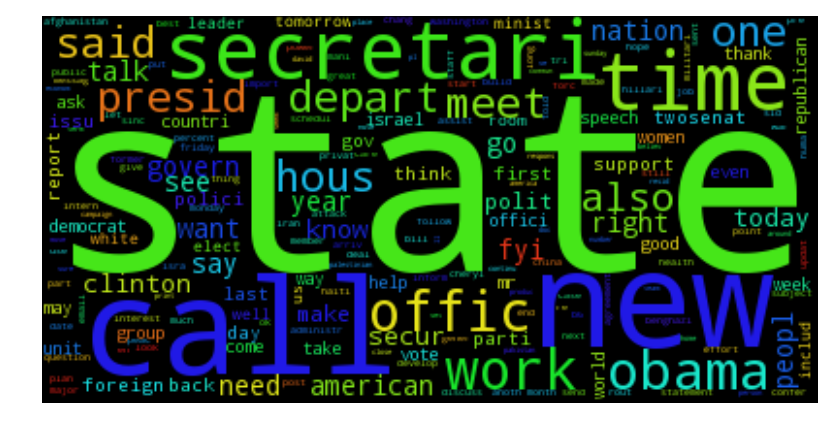

In [26]:
wordcloud = WordCloud().generate(' '.join(stems))
plt.subplots(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

One problem now, is that we have words that are not actual words. For exemple, `secretary` was stemmed to `secretari`, which doesn't exist.

### Lemmatization

We apply the same concept of reducing each token to a more general form as in stemming. However, we will reduce to the root form of the token, not to its stem.

In [27]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmas = [lemmatizer.lemmatize(token) for token in filtered_tokens]

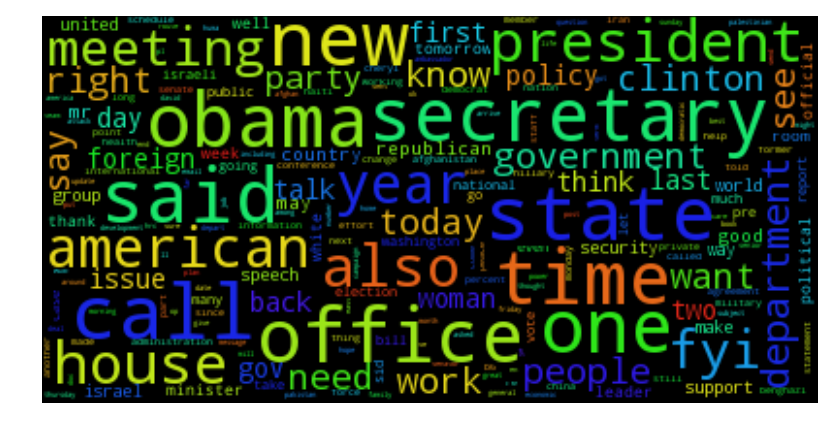

In [28]:
wordcloud = WordCloud(max_font_size=40).generate(' '.join(lemmas))
plt.subplots(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We can see that this is much more satisfying.

## Part 2 - Countries

In [29]:
import pycountry
import difflib

In [30]:
pycountry.countries

In [31]:
country_names = [ x.name.lower() for x in pycountry.countries]

In [32]:
country_codes = [[lower_case(x.alpha_2), lower_case(x.alpha_3)] for x in pycountry.countries]
country_codes = [item for country_code_sublist in country_codes for item in country_code_sublist]

NameError: name 'lower_case' is not defined

In [ ]:
country_dic_list = [ {lower_case(x.name)    :x.name.lower(),
                      lower_case(x.alpha_2) :x.name.lower(), 
                      lower_case(x.alpha_3) :x.name.lower()} for x in pycountry.countries ]

country_dic = {k: v for dic in country_dic_list for k, v in dic.items()}

In [ ]:
test = [item for item in lemmatised_words if item in country_dic ]
len(test) / len(lemmatised_words)

In [ ]:
countries = [item if item not in country_dic else country_dic.get(item) for item in lemmatised_words]